<a href="https://colab.research.google.com/github/TerMinator-spec/Stock-market-predictor/blob/master/HHHL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, merge, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd

In [27]:
!pip install pyti

In [3]:
import pandas as pd
import numpy as np

In [4]:
data=pd.read_csv('bankniftyoneminutefinal.csv')

In [5]:
data['date_time']=pd.to_datetime(data['date'] + ' ' + data['time'])

In [6]:
data=data.drop('Unnamed: 6',axis=1)

In [7]:
data=data.set_index('date_time')

In [9]:
data.to_csv('tr_data.csv')

In [96]:
data.head()

,date,time,open,high,low,close
date_time,,,,,,
2015-01-09 09:15:00,1/9/2015,9:15:00,18845.9,18845.90,18801.70,18801.70
2015-01-09 09:16:00,1/9/2015,9:16:00,18801.7,18806.05,18790.20,18794.65
2015-01-09 09:17:00,1/9/2015,9:17:00,18796.0,18829.00,18794.65,18827.30
2015-01-09 09:18:00,1/9/2015,9:18:00,18827.3,18864.00,18827.30,18862.10
2015-01-09 09:19:00,1/9/2015,9:19:00,18862.1,18862.10,18843.55,18849.25


In [11]:
def resample_stock_data(df, timedelta):
    # make a copy
        df = df.copy()

        # convert index to datetime
        df.index = pd.to_datetime(df.index)

        # sort the index (evidently required by resample())
        df = df.sort_index()

        aggregation_dict = {
             'open': 'first', 
             'high': 'max',
             'low': 'min',
             'close': 'last',

        }

        rename_dict = {
            'open': 'open',
            'high': 'high',
            'low': 'low',
            'close': 'close',

        }


        return (df
          .resample(timedelta)
          .agg(aggregation_dict)
          .rename(columns=rename_dict)
        )

In [29]:
data_10=resample_stock_data(data,'10min')

In [30]:
data_10=data_10.dropna()

In [31]:
data_10.head()

,open,high,low,close
date_time,,,,
2015-01-09 09:10:00,18845.90,18864.00,18790.2,18849.25
2015-01-09 09:20:00,18849.25,18859.65,18799.4,18815.15
2015-01-09 09:30:00,18815.15,18821.40,18772.9,18800.05
2015-01-09 09:40:00,18800.05,18814.25,18758.5,18779.40
2015-01-09 09:50:00,18783.05,18808.30,18761.1,18802.90


In [32]:
data_10['close_lag']=data_10['close'].shift(1)

In [33]:
data_10=data_10.dropna()

In [34]:
data_10['position']=np.where(data_10['close']> data_10['close_lag'], 1, 0) 

In [35]:
data_10.head()

,open,high,low,close,close_lag,position
date_time,,,,,,
2015-01-09 09:20:00,18849.25,18859.65,18799.40,18815.15,18849.25,0
2015-01-09 09:30:00,18815.15,18821.40,18772.90,18800.05,18815.15,0
2015-01-09 09:40:00,18800.05,18814.25,18758.50,18779.40,18800.05,0
2015-01-09 09:50:00,18783.05,18808.30,18761.10,18802.90,18779.40,1
2015-01-09 10:00:00,18802.90,18813.60,18783.55,18783.55,18802.90,0


In [36]:
data_10=data_10.drop('close_lag',1)

In [37]:
data_10.head()

,open,high,low,close,position
date_time,,,,,
2015-01-09 09:20:00,18849.25,18859.65,18799.40,18815.15,0
2015-01-09 09:30:00,18815.15,18821.40,18772.90,18800.05,0
2015-01-09 09:40:00,18800.05,18814.25,18758.50,18779.40,0
2015-01-09 09:50:00,18783.05,18808.30,18761.10,18802.90,1
2015-01-09 10:00:00,18802.90,18813.60,18783.55,18783.55,0


In [78]:
DATA=data_10

In [79]:
DATA['hour'] = DATA.index.hour
DATA['day']  = DATA.index.weekday
DATA['week'] = DATA.index.week

DATA['close']  = pd.to_numeric(DATA['close'])
DATA['open']   = pd.to_numeric(DATA['open'])

DATA['avg_price']  = (DATA['low'] + DATA['high'])/2
DATA['range']      = DATA['high'] - DATA['low']
DATA['ohlc_price'] = (DATA['low'] + DATA['high'] + DATA['open'] + DATA['close'])/4
DATA['oc_diff']      = DATA['open'] - DATA['close']
DATA['RSI'] = rsi(DATA['close'],  14)
DATA['MACD'] = macd(DATA['close'], 12, 26)

# inputs = {
#     'open'   : DATA['open'].values,
#     'high'   : DATA['high'].values,
#     'low'    : DATA['low'].values,
#     'close'  : DATA['close'].values,
    
# }
DATA['ema'] = ema(DATA["close"], 15)
#DATA['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
DATA['bear_power'] = DATA['low'] - DATA['ema']
DATA['bull_power'] = DATA['high'] - DATA['ema']
# Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
DATA.dropna(inplace=True)
# Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
pca_input = DATA.drop('close',1).copy()
pca_features = pca_input.columns.tolist()
pca = PCA(n_components=1)
DATA['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
DATA.head()

,open,high,low,close,position,hour,day,week,avg_price,range,ohlc_price,oc_diff,RSI,MACD,ema,bear_power,bull_power,pca
date_time,,,,,,,,,,,,,,,,,,
2015-01-12 11:20:00,18712.55,18723.40,18709.10,18723.40,1,11,0,3,18716.250,14.30,18717.1125,-10.85,58.971726,46.923764,18710.091660,-0.991660,13.308340,-14940.680664
2015-01-12 11:30:00,18726.40,18747.60,18719.25,18719.25,0,11,0,3,18733.425,28.35,18728.1250,7.15,58.229545,45.355798,18713.599563,5.650437,34.000437,-14894.579102
2015-01-12 11:40:00,18719.25,18721.60,18705.35,18719.90,1,11,0,3,18713.475,16.25,18716.5250,-0.65,58.318029,41.590213,18717.521359,-12.171359,4.078641,-14937.721680
2015-01-12 11:50:00,18719.90,18740.90,18719.90,18735.00,1,11,0,3,18730.400,21.00,18728.9250,-15.10,60.415832,36.784534,18723.109498,-3.209498,17.790502,-14897.633789
2015-01-12 12:00:00,18734.10,18743.55,18709.75,18716.70,0,12,0,3,18726.650,33.80,18726.0250,17.40,56.691944,31.070960,18725.284621,-15.534621,18.265379,-14896.339844


In [81]:
dates=DATA.index

In [82]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [83]:
LOOK_BACK  = 20
SPLIT      = 0.80  

In [84]:
DATA.head()

,open,high,low,close,position,hour,day,week,avg_price,range,ohlc_price,oc_diff,RSI,MACD,ema,bear_power,bull_power,pca
date_time,,,,,,,,,,,,,,,,,,
2015-01-12 11:20:00,18712.55,18723.40,18709.10,18723.40,1,11,0,3,18716.250,14.30,18717.1125,-10.85,58.971726,46.923764,18710.091660,-0.991660,13.308340,-14940.680664
2015-01-12 11:30:00,18726.40,18747.60,18719.25,18719.25,0,11,0,3,18733.425,28.35,18728.1250,7.15,58.229545,45.355798,18713.599563,5.650437,34.000437,-14894.579102
2015-01-12 11:40:00,18719.25,18721.60,18705.35,18719.90,1,11,0,3,18713.475,16.25,18716.5250,-0.65,58.318029,41.590213,18717.521359,-12.171359,4.078641,-14937.721680
2015-01-12 11:50:00,18719.90,18740.90,18719.90,18735.00,1,11,0,3,18730.400,21.00,18728.9250,-15.10,60.415832,36.784534,18723.109498,-3.209498,17.790502,-14897.633789
2015-01-12 12:00:00,18734.10,18743.55,18709.75,18716.70,0,12,0,3,18726.650,33.80,18726.0250,17.40,56.691944,31.070960,18725.284621,-15.534621,18.265379,-14896.339844


In [85]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(DATA), columns=DATA.columns)
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(DATA.drop('close', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(DATA['close'].values.astype('float32').reshape(-1,1))

In [86]:
target_index = scaled.columns.tolist().index('position')
target_index2 = scaled.columns.tolist().index('close')
dataset = scaled.values.astype('float32')
X, y = create_dataset(dataset, look_back=LOOK_BACK)
y2 = y[:,target_index2]
y = y[:,target_index]
train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]
testY_close = y2[train_size:]

In [73]:
testY

array([0., 1., 0., ..., 1., 1., 0.], dtype=float32)

In [87]:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='sigmoid'))

In [88]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard as tensorboard

In [89]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
model.fit(trainX, trainY, epochs=100, batch_size=500)

Epoch 1/100
89/89 [==============================] - 6s 67ms/step - loss: 0.6931 - accuracy: 0.5058
Epoch 2/100
89/89 [==============================] - 6s 70ms/step - loss: 0.6931 - accuracy: 0.5058
Epoch 3/100
89/89 [==============================] - 6s 71ms/step - loss: 0.6931 - accuracy: 0.5058
Epoch 4/100
18/89 [=====>........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.5103

KeyboardInterrupt: ignored

In [90]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Enable this line if you want to monitor the trianing progress via TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=100, batch_size=50, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
793/793 [==============================] - 32s 32ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 2/100
 13/793 [..............................] - ETA: 24s - loss: 0.6918 - accuracy: 0.5509

KeyboardInterrupt: ignored

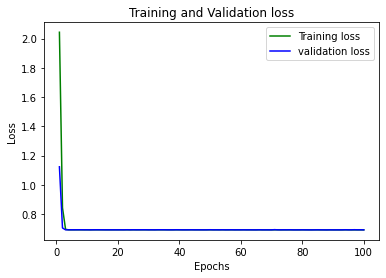

In [61]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
pred=model.predict(testX)

In [66]:
pred[:60]

array([[0.49679047],
       [0.49611583],
       [0.49537113],
       [0.49491674],
       [0.4946076 ],
       [0.49454764],
       [0.49456093],
       [0.49444622],
       [0.4943411 ],
       [0.49425325],
       [0.49426624],
       [0.49471536],
       [0.49520507],
       [0.49543756],
       [0.49574378],
       [0.49582154],
       [0.49584034],
       [0.49548444],
       [0.4959005 ],
       [0.49621704],
       [0.49630928],
       [0.4965699 ],
       [0.49647543],
       [0.4968791 ],
       [0.4971485 ],
       [0.49821937],
       [0.49933767],
       [0.50030357],
       [0.50041336],
       [0.50106627],
       [0.50210494],
       [0.5025334 ],
       [0.50287116],
       [0.50269973],
       [0.5025491 ],
       [0.5014866 ],
       [0.50055474],
       [0.49951246],
       [0.49926442],
       [0.49842083],
       [0.498078  ],
       [0.49761567],
       [0.49717227],
       [0.49698746],
       [0.49688295],
       [0.49700084],
       [0.49717346],
       [0.497

In [63]:
test3=y_scaler.inverse_transform(testY_close.reshape(-1,1))

In [93]:
!pip install mpl_finance

In [94]:
import pandas as pd
import numpy as np
#import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14)

In [122]:
data_15=resample_stock_data(data,'15min')

In [123]:
data_15=data_15.dropna()

In [125]:
data_15.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

In [126]:
data_15['Date'] = pd.to_datetime(data_15.index)

In [103]:
data_15.head()

,open,high,low,close,Date
date_time,,,,,
2015-01-09 09:15:00,18845.90,18864.0,18790.20,18815.15,2015-01-09 09:15:00
2015-01-09 09:30:00,18815.15,18821.4,18758.50,18771.60,2015-01-09 09:30:00
2015-01-09 09:45:00,18774.15,18808.3,18761.10,18802.90,2015-01-09 09:45:00
2015-01-09 10:00:00,18802.90,18813.6,18758.50,18781.15,2015-01-09 10:00:00
2015-01-09 10:15:00,18781.15,18807.1,18769.45,18803.00,2015-01-09 10:15:00


In [127]:
data_15['Date'] = data_15['Date'].apply(mpl_dates.date2num)

In [128]:
data_15.head()

,open,high,low,close,Date
date_time,,,,,
2015-01-09 09:15:00,18845.90,18864.0,18790.20,18815.15,735607.385417
2015-01-09 09:30:00,18815.15,18821.4,18758.50,18771.60,735607.395833
2015-01-09 09:45:00,18774.15,18808.3,18761.10,18802.90,735607.406250
2015-01-09 10:00:00,18802.90,18813.6,18758.50,18781.15,735607.416667
2015-01-09 10:15:00,18781.15,18807.1,18769.45,18803.00,735607.427083


In [129]:
def isSupport(df,i):
  support = df['low'][i] < df['low'][i-1]  and df['low'][i] < df['low'][i+1] \
  and df['low'][i+1] < df['low'][i+2] and df['low'][i-1] < df['low'][i-2]

  return support

def isResistance(df,i):
  resistance = df['high'][i] > df['high'][i-1]  and df['high'][i] > df['high'][i+1] \
  and df['high'][i+1] > df['high'][i+2] and df['high'][i-1] > df['high'][i-2] 

  return resistance

In [189]:
df2 = data_15.loc[:,['Date', 'open', 'high', 'low', 'close']]

In [190]:
df=df2.loc['2015-01-12']

In [191]:
df

,Date,open,high,low,close
date_time,,,,,
2015-01-12 09:15:00,735610.385417,18632.00,18632.00,18530.10,18560.45
2015-01-12 09:30:00,735610.395833,18560.45,18646.85,18533.80,18646.85
2015-01-12 09:45:00,735610.406250,18647.90,18737.10,18631.15,18729.95
2015-01-12 10:00:00,735610.416667,18729.95,18755.75,18708.75,18748.15
2015-01-12 10:15:00,735610.427083,18748.15,18787.70,18742.80,18765.95
2015-01-12 10:30:00,735610.437500,18763.15,18765.95,18728.95,18747.50
2015-01-12 10:45:00,735610.447917,18747.50,18749.15,18701.70,18723.40
2015-01-12 11:00:00,735610.458333,18723.40,18742.80,18720.90,18725.80
2015-01-12 11:15:00,735610.468750,18725.80,18725.80,18702.70,18723.40


In [192]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    levels.append((i,df['low'][i]))
  elif isResistance(df,i):
    levels.append((i,df['high'][i]))

In [193]:
def plot_all(df):
  fig, ax = plt.subplots()

  candlestick_ohlc(ax,df.values,width=0.01, \
                   colorup='green', colordown='red', alpha=0.8)

  date_format = mpl_dates.DateFormatter('%Y-%m-%d %H:%M:%S')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()

  fig.tight_layout()

  for level in levels:
    plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='blue')
  fig.show()

In [154]:
plt.close()

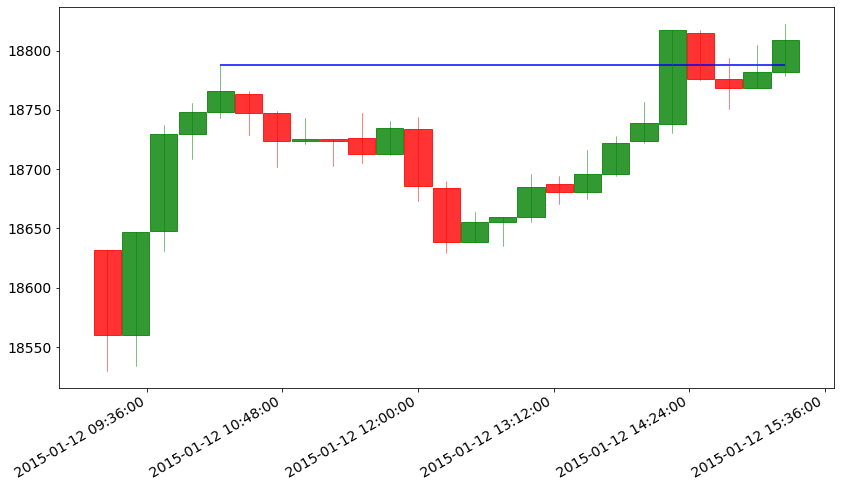

In [194]:
plot_all(df)

In [196]:
levels = []
low_high=[]
date=[]
indx=[]
for i in range(2,df2.shape[0]-2):
  if isSupport(df2,i):
    indx.append(i)
    date.append(df2.index[i])
    low_high.append('low')
    levels.append(df2['low'][i])
  elif isResistance(df2,i):
    indx.append(i)
    date.append(df2.index[i])
    low_high.append('high')
    levels.append(df2['high'][i])

In [197]:
dicts={'index':indx, 'datetime':date, 'low_or_high':low_high, 'levels':levels}

In [198]:
df_trend=pd.DataFrame(dicts)

In [206]:
df_trend.head(60)

,index,datetime,low_or_high,levels
0,19,2015-01-09 14:00:00,low,18479.65
1,23,2015-01-09 15:00:00,high,18678.35
2,25,2015-01-12 09:15:00,low,18530.10
3,29,2015-01-12 10:15:00,high,18787.70
4,63,2015-01-13 12:30:00,low,18801.75
5,67,2015-01-13 13:30:00,high,18917.05
6,72,2015-01-13 14:45:00,low,18642.80
7,77,2015-01-14 09:45:00,high,18769.65
8,79,2015-01-14 10:15:00,low,18661.10
9,95,2015-01-14 14:15:00,high,18677.50


In [207]:
trend=[]
for i in range(2,len(df_trend)):
  if((df_trend['low_or_high'][i]!=df_trend['low_or_high'][i-1]) and (df_trend['levels'][i]>df_trend['levels'][i-2])):
    trend.append('uptrend')
  elif((df_trend['low_or_high'][i]!=df_trend['low_or_high'][i-1]) and (df_trend['levels'][i]<df_trend['levels'][i-2])):
    trend.append('downtrend')
  else:
    trend.append('No trend')



In [209]:
trend.insert(0,'No trend')
trend.insert(0,'No trend')

In [210]:
df_trend['trend']=trend

In [211]:
df_trend.head(60)

,index,datetime,low_or_high,levels,trend
0,19,2015-01-09 14:00:00,low,18479.65,No trend
1,23,2015-01-09 15:00:00,high,18678.35,No trend
2,25,2015-01-12 09:15:00,low,18530.10,uptrend
3,29,2015-01-12 10:15:00,high,18787.70,uptrend
4,63,2015-01-13 12:30:00,low,18801.75,uptrend
5,67,2015-01-13 13:30:00,high,18917.05,uptrend
6,72,2015-01-13 14:45:00,low,18642.80,downtrend
7,77,2015-01-14 09:45:00,high,18769.65,downtrend
8,79,2015-01-14 10:15:00,low,18661.10,uptrend
9,95,2015-01-14 14:15:00,high,18677.50,downtrend


In [201]:
import seaborn as sns

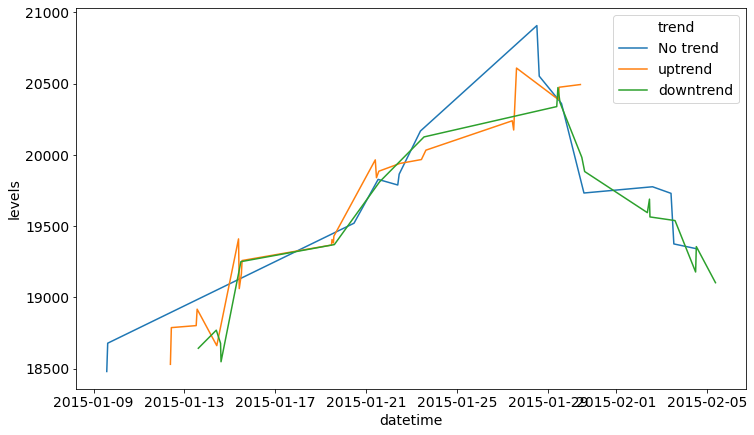

In [212]:
sns.lineplot(x='datetime', y='levels', hue='trend', data=df_trend[:60])

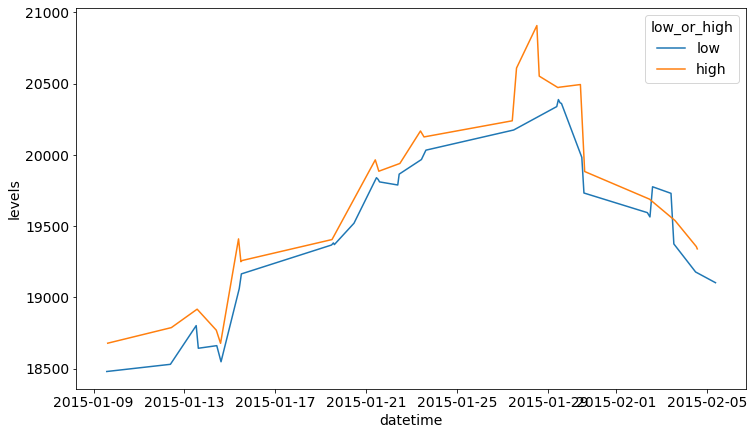

In [205]:
sns.lineplot(x='datetime', y='levels', hue='low_or_high', data=df_trend[:60])

In [186]:
levels

[(19, Timestamp('2015-01-09 14:00:00'), 'low', 18479.65),
 (23, Timestamp('2015-01-09 15:00:00'), 'high', 18678.35),
 (25, Timestamp('2015-01-12 09:15:00'), 'low', 18530.1),
 (29, Timestamp('2015-01-12 10:15:00'), 'high', 18787.7),
 (63, Timestamp('2015-01-13 12:30:00'), 'low', 18801.75),
 (67, Timestamp('2015-01-13 13:30:00'), 'high', 18917.05),
 (72, Timestamp('2015-01-13 14:45:00'), 'low', 18642.8),
 (77, Timestamp('2015-01-14 09:45:00'), 'high', 18769.65),
 (79, Timestamp('2015-01-14 10:15:00'), 'low', 18661.1),
 (95, Timestamp('2015-01-14 14:15:00'), 'high', 18677.5),
 (97, Timestamp('2015-01-14 14:45:00'), 'low', 18547.95),
 (100, Timestamp('2015-01-15 09:15:00'), 'high', 19410.4),
 (103, Timestamp('2015-01-15 10:00:00'), 'low', 19061.35),
 (110, Timestamp('2015-01-15 11:45:00'), 'high', 19250.55),
 (112, Timestamp('2015-01-15 12:15:00'), 'low', 19164.7),
 (115, Timestamp('2015-01-15 13:00:00'), 'high', 19258.6),
 (134, Timestamp('2015-01-19 11:30:00'), 'low', 19367.35),
 (136, T